# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/recon_max_sparse_top_{N}_v4.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/recon_max_sparse_ablated_top_{N}_v4.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

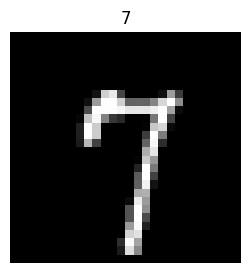

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [15]:
min_loss = 0.005
max_loss = 0.011
step = 0.001
loss_factors = np.arange(min_loss, round(max_loss + step, 3), step)
print(len(loss_factors))
print(loss_factors)

7
[0.005 0.006 0.007 0.008 0.009 0.01  0.011]


In [16]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.005




Epoch 1/20
  Train Loss: 1.0191
  SAE Train Loss (hidden one): 8.7384
  SAE Train Loss (hidden two): 1.1919
  Val Loss: 0.5887 | Val Acc: 85.42%
  Saved model with Val Acc: 85.42%


Epoch 2/20
  Train Loss: 0.4934
  SAE Train Loss (hidden one): 0.4265
  SAE Train Loss (hidden two): 0.0943
  Val Loss: 0.4414 | Val Acc: 87.59%
  Saved model with Val Acc: 87.59%


Epoch 3/20
  Train Loss: 0.3976
  SAE Train Loss (hidden one): 0.4737
  SAE Train Loss (hidden two): 0.0875
  Val Loss: 0.4064 | Val Acc: 89.06%
  Saved model with Val Acc: 89.06%


Epoch 4/20
  Train Loss: 0.3657
  SAE Train Loss (hidden one): 0.4453
  SAE Train Loss (hidden two): 0.0761
  Val Loss: 0.3803 | Val Acc: 88.85%


Epoch 5/20
  Train Loss: 0.3512
  SAE Train Loss (hidden one): 0.4743
  SAE Train Loss (hidden two): 0.0716
  Val Loss: 0.3883 | Val Acc: 88.80%


Epoch 6/20
  Train Loss: 0.3367
  SAE Train Loss (hidden one): 0.5772
  SAE Train Loss (hidden two): 0.0660
  Val Loss: 0.3568 | Val Acc: 90.10%
  Saved model with Val Acc: 90.10%


Epoch 7/20
  Train Loss: 0.3262
  SAE Train Loss (hidden one): 0.5413
  SAE Train Loss (hidden two): 0.0628
  Val Loss: 0.3502 | Val Acc: 90.39%
  Saved model with Val Acc: 90.39%


Epoch 8/20
  Train Loss: 0.3189
  SAE Train Loss (hidden one): 0.5474
  SAE Train Loss (hidden two): 0.0607
  Val Loss: 0.3407 | Val Acc: 90.39%
  Saved model with same Val Acc: 90.39% but lower Val Loss: 0.3407


Epoch 9/20
  Train Loss: 0.3132
  SAE Train Loss (hidden one): 0.5076
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.3598 | Val Acc: 89.54%


Epoch 10/20
  Train Loss: 0.3056
  SAE Train Loss (hidden one): 0.4947
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3467 | Val Acc: 90.09%


Epoch 11/20
  Train Loss: 0.3000
  SAE Train Loss (hidden one): 0.5146
  SAE Train Loss (hidden two): 0.0501
  Val Loss: 0.3414 | Val Acc: 90.49%
  Saved model with Val Acc: 90.49%


Epoch 12/20
  Train Loss: 0.2979
  SAE Train Loss (hidden one): 0.5173
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.3402 | Val Acc: 90.14%


Epoch 13/20
  Train Loss: 0.2925
  SAE Train Loss (hidden one): 0.5290
  SAE Train Loss (hidden two): 0.0467
  Val Loss: 0.3256 | Val Acc: 90.57%
  Saved model with Val Acc: 90.57%


Epoch 14/20
  Train Loss: 0.2907
  SAE Train Loss (hidden one): 0.5107
  SAE Train Loss (hidden two): 0.0453
  Val Loss: 0.3341 | Val Acc: 90.57%


Epoch 15/20
  Train Loss: 0.2868
  SAE Train Loss (hidden one): 0.5156
  SAE Train Loss (hidden two): 0.0428
  Val Loss: 0.3268 | Val Acc: 90.87%
  Saved model with Val Acc: 90.87%


Epoch 16/20
  Train Loss: 0.2849
  SAE Train Loss (hidden one): 0.5525
  SAE Train Loss (hidden two): 0.0421
  Val Loss: 0.3227 | Val Acc: 90.81%


Epoch 17/20
  Train Loss: 0.2822
  SAE Train Loss (hidden one): 0.5128
  SAE Train Loss (hidden two): 0.0407
  Val Loss: 0.3232 | Val Acc: 90.74%


Epoch 18/20
  Train Loss: 0.2785
  SAE Train Loss (hidden one): 0.5426
  SAE Train Loss (hidden two): 0.0397
  Val Loss: 0.3129 | Val Acc: 91.20%
  Saved model with Val Acc: 91.20%


Epoch 19/20
  Train Loss: 0.2772
  SAE Train Loss (hidden one): 0.4979
  SAE Train Loss (hidden two): 0.0375
  Val Loss: 0.3401 | Val Acc: 90.31%


Epoch 20/20
  Train Loss: 0.2777
  SAE Train Loss (hidden one): 0.5834
  SAE Train Loss (hidden two): 0.0374
  Val Loss: 0.3211 | Val Acc: 90.82%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 270.20it/s]


Final Test Accuracy: 91.30%
Average Reconstruction Error (Hidden One): 0.0691
Average Reconstruction Error (Hidden Two): 0.0077
Average Non-Zero Features per Image (Hidden One): 32.53
Average Non-Zero Features per Image (Hidden Two): 33.96


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.43%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.52%

##################################################
Loss factor: 0.006




Epoch 1/20
  Train Loss: 1.0091
  SAE Train Loss (hidden one): 8.7469
  SAE Train Loss (hidden two): 1.1936
  Val Loss: 0.5853 | Val Acc: 85.24%
  Saved model with Val Acc: 85.24%


Epoch 2/20
  Train Loss: 0.4897
  SAE Train Loss (hidden one): 0.4281
  SAE Train Loss (hidden two): 0.0927
  Val Loss: 0.4508 | Val Acc: 87.50%
  Saved model with Val Acc: 87.50%


Epoch 3/20
  Train Loss: 0.3965
  SAE Train Loss (hidden one): 0.4680
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.4070 | Val Acc: 88.88%
  Saved model with Val Acc: 88.88%


Epoch 4/20
  Train Loss: 0.3666
  SAE Train Loss (hidden one): 0.4532
  SAE Train Loss (hidden two): 0.0741
  Val Loss: 0.3691 | Val Acc: 89.36%
  Saved model with Val Acc: 89.36%


Epoch 5/20
  Train Loss: 0.3508
  SAE Train Loss (hidden one): 0.4803
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3519 | Val Acc: 89.63%
  Saved model with Val Acc: 89.63%


Epoch 6/20
  Train Loss: 0.3340
  SAE Train Loss (hidden one): 0.4941
  SAE Train Loss (hidden two): 0.0629
  Val Loss: 0.3402 | Val Acc: 90.44%
  Saved model with Val Acc: 90.44%


Epoch 7/20
  Train Loss: 0.3260
  SAE Train Loss (hidden one): 0.5398
  SAE Train Loss (hidden two): 0.0646
  Val Loss: 0.3458 | Val Acc: 90.28%


Epoch 8/20
  Train Loss: 0.3170
  SAE Train Loss (hidden one): 0.5712
  SAE Train Loss (hidden two): 0.0601
  Val Loss: 0.3314 | Val Acc: 90.39%


Epoch 9/20
  Train Loss: 0.3058
  SAE Train Loss (hidden one): 0.5238
  SAE Train Loss (hidden two): 0.0547
  Val Loss: 0.3564 | Val Acc: 89.74%


Epoch 10/20
  Train Loss: 0.3010
  SAE Train Loss (hidden one): 0.5421
  SAE Train Loss (hidden two): 0.0523
  Val Loss: 0.3637 | Val Acc: 89.39%


Epoch 11/20
  Train Loss: 0.2962
  SAE Train Loss (hidden one): 0.5572
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3279 | Val Acc: 90.81%
  Saved model with Val Acc: 90.81%


Epoch 12/20
  Train Loss: 0.2909
  SAE Train Loss (hidden one): 0.5533
  SAE Train Loss (hidden two): 0.0495
  Val Loss: 0.3305 | Val Acc: 90.45%


Epoch 13/20
  Train Loss: 0.2887
  SAE Train Loss (hidden one): 0.5664
  SAE Train Loss (hidden two): 0.0478
  Val Loss: 0.3225 | Val Acc: 90.79%


Epoch 14/20
  Train Loss: 0.2859
  SAE Train Loss (hidden one): 0.5126
  SAE Train Loss (hidden two): 0.0461
  Val Loss: 0.3258 | Val Acc: 90.53%


Epoch 15/20
  Train Loss: 0.2826
  SAE Train Loss (hidden one): 0.5395
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3341 | Val Acc: 90.56%


Epoch 16/20
  Train Loss: 0.2817
  SAE Train Loss (hidden one): 0.5509
  SAE Train Loss (hidden two): 0.0435
  Val Loss: 0.3129 | Val Acc: 90.75%


Epoch 17/20
  Train Loss: 0.2767
  SAE Train Loss (hidden one): 0.5306
  SAE Train Loss (hidden two): 0.0424
  Val Loss: 0.3150 | Val Acc: 91.13%
  Saved model with Val Acc: 91.13%


Epoch 18/20
  Train Loss: 0.2770
  SAE Train Loss (hidden one): 0.6043
  SAE Train Loss (hidden two): 0.0419
  Val Loss: 0.3257 | Val Acc: 90.50%


Epoch 19/20
  Train Loss: 0.2756
  SAE Train Loss (hidden one): 0.4816
  SAE Train Loss (hidden two): 0.0391
  Val Loss: 0.3381 | Val Acc: 90.05%


Epoch 20/20
  Train Loss: 0.2724
  SAE Train Loss (hidden one): 0.5674
  SAE Train Loss (hidden two): 0.0402
  Val Loss: 0.3185 | Val Acc: 90.89%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 293.36it/s]


Final Test Accuracy: 91.07%
Average Reconstruction Error (Hidden One): 0.5597
Average Reconstruction Error (Hidden Two): 0.0165
Average Non-Zero Features per Image (Hidden One): 32.54
Average Non-Zero Features per Image (Hidden Two): 33.59


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.72%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 88.97%

##################################################
Loss factor: 0.007




Epoch 1/20
  Train Loss: 1.0413
  SAE Train Loss (hidden one): 8.8959
  SAE Train Loss (hidden two): 1.2068
  Val Loss: 0.6395 | Val Acc: 84.22%
  Saved model with Val Acc: 84.22%


Epoch 2/20
  Train Loss: 0.5141
  SAE Train Loss (hidden one): 0.5551
  SAE Train Loss (hidden two): 0.1110
  Val Loss: 0.4295 | Val Acc: 88.35%
  Saved model with Val Acc: 88.35%


Epoch 3/20
  Train Loss: 0.3961
  SAE Train Loss (hidden one): 0.5282
  SAE Train Loss (hidden two): 0.0896
  Val Loss: 0.3909 | Val Acc: 89.12%
  Saved model with Val Acc: 89.12%


Epoch 4/20
  Train Loss: 0.3624
  SAE Train Loss (hidden one): 0.5237
  SAE Train Loss (hidden two): 0.0796
  Val Loss: 0.3623 | Val Acc: 89.57%
  Saved model with Val Acc: 89.57%


Epoch 5/20
  Train Loss: 0.3470
  SAE Train Loss (hidden one): 0.5020
  SAE Train Loss (hidden two): 0.0729
  Val Loss: 0.3693 | Val Acc: 89.35%


Epoch 6/20
  Train Loss: 0.3308
  SAE Train Loss (hidden one): 0.4946
  SAE Train Loss (hidden two): 0.0674
  Val Loss: 0.3620 | Val Acc: 89.76%
  Saved model with Val Acc: 89.76%


Epoch 7/20
  Train Loss: 0.3236
  SAE Train Loss (hidden one): 0.5024
  SAE Train Loss (hidden two): 0.0618
  Val Loss: 0.3475 | Val Acc: 90.11%
  Saved model with Val Acc: 90.11%


Epoch 8/20
  Train Loss: 0.3214
  SAE Train Loss (hidden one): 0.5283
  SAE Train Loss (hidden two): 0.0590
  Val Loss: 0.3460 | Val Acc: 90.35%
  Saved model with Val Acc: 90.35%


Epoch 9/20
  Train Loss: 0.3115
  SAE Train Loss (hidden one): 0.5096
  SAE Train Loss (hidden two): 0.0566
  Val Loss: 0.3466 | Val Acc: 90.03%


Epoch 10/20
  Train Loss: 0.3122
  SAE Train Loss (hidden one): 0.4613
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3384 | Val Acc: 90.41%
  Saved model with Val Acc: 90.41%


Epoch 11/20
  Train Loss: 0.3056
  SAE Train Loss (hidden one): 0.5086
  SAE Train Loss (hidden two): 0.0503
  Val Loss: 0.3353 | Val Acc: 90.57%
  Saved model with Val Acc: 90.57%


Epoch 12/20
  Train Loss: 0.3031
  SAE Train Loss (hidden one): 0.4866
  SAE Train Loss (hidden two): 0.0496
  Val Loss: 0.3332 | Val Acc: 90.43%


Epoch 13/20
  Train Loss: 0.2998
  SAE Train Loss (hidden one): 0.5382
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.3593 | Val Acc: 89.94%


Epoch 14/20
  Train Loss: 0.2947
  SAE Train Loss (hidden one): 0.5041
  SAE Train Loss (hidden two): 0.0462
  Val Loss: 0.3532 | Val Acc: 90.26%


Epoch 15/20
  Train Loss: 0.2941
  SAE Train Loss (hidden one): 0.4860
  SAE Train Loss (hidden two): 0.0442
  Val Loss: 0.3408 | Val Acc: 90.18%


Epoch 16/20
  Train Loss: 0.2880
  SAE Train Loss (hidden one): 0.5059
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.3275 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 17/20
  Train Loss: 0.2902
  SAE Train Loss (hidden one): 0.5485
  SAE Train Loss (hidden two): 0.0420
  Val Loss: 0.3248 | Val Acc: 90.96%
  Saved model with Val Acc: 90.96%


Epoch 18/20
  Train Loss: 0.2843
  SAE Train Loss (hidden one): 0.4869
  SAE Train Loss (hidden two): 0.0421
  Val Loss: 0.3312 | Val Acc: 90.36%


Epoch 19/20
  Train Loss: 0.2861
  SAE Train Loss (hidden one): 0.5691
  SAE Train Loss (hidden two): 0.0391
  Val Loss: 0.3320 | Val Acc: 90.31%


Epoch 20/20
  Train Loss: 0.2838
  SAE Train Loss (hidden one): 0.4749
  SAE Train Loss (hidden two): 0.0416
  Val Loss: 0.3280 | Val Acc: 90.82%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 271.52it/s]

Final Test Accuracy: 90.82%
Average Reconstruction Error (Hidden One): 2.0794
Average Reconstruction Error (Hidden Two): 0.0147
Average Non-Zero Features per Image (Hidden One): 32.38
Average Non-Zero Features per Image (Hidden Two): 33.46



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.37%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 83.86%

##################################################
Loss factor: 0.008




Epoch 1/20
  Train Loss: 1.0457
  SAE Train Loss (hidden one): 8.9274
  SAE Train Loss (hidden two): 1.1730
  Val Loss: 0.5997 | Val Acc: 85.61%
  Saved model with Val Acc: 85.61%


Epoch 2/20
  Train Loss: 0.4821
  SAE Train Loss (hidden one): 0.4196
  SAE Train Loss (hidden two): 0.0899
  Val Loss: 0.4215 | Val Acc: 88.15%
  Saved model with Val Acc: 88.15%


Epoch 3/20
  Train Loss: 0.3768
  SAE Train Loss (hidden one): 0.4754
  SAE Train Loss (hidden two): 0.0825
  Val Loss: 0.4031 | Val Acc: 88.44%
  Saved model with Val Acc: 88.44%


Epoch 4/20
  Train Loss: 0.3428
  SAE Train Loss (hidden one): 0.5373
  SAE Train Loss (hidden two): 0.0775
  Val Loss: 0.3414 | Val Acc: 90.18%
  Saved model with Val Acc: 90.18%


Epoch 5/20
  Train Loss: 0.3259
  SAE Train Loss (hidden one): 0.5429
  SAE Train Loss (hidden two): 0.0702
  Val Loss: 0.3612 | Val Acc: 89.38%


Epoch 6/20
  Train Loss: 0.3144
  SAE Train Loss (hidden one): 0.6274
  SAE Train Loss (hidden two): 0.0679
  Val Loss: 0.3416 | Val Acc: 90.27%
  Saved model with Val Acc: 90.27%


Epoch 7/20
  Train Loss: 0.3021
  SAE Train Loss (hidden one): 0.5710
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.3068 | Val Acc: 90.99%
  Saved model with Val Acc: 90.99%


Epoch 8/20
  Train Loss: 0.2933
  SAE Train Loss (hidden one): 0.6407
  SAE Train Loss (hidden two): 0.0622
  Val Loss: 0.3113 | Val Acc: 91.08%
  Saved model with Val Acc: 91.08%


Epoch 9/20
  Train Loss: 0.2882
  SAE Train Loss (hidden one): 0.6255
  SAE Train Loss (hidden two): 0.0572
  Val Loss: 0.3348 | Val Acc: 89.94%


Epoch 10/20
  Train Loss: 0.2804
  SAE Train Loss (hidden one): 0.5917
  SAE Train Loss (hidden two): 0.0557
  Val Loss: 0.3230 | Val Acc: 90.36%


Epoch 11/20
  Train Loss: 0.2764
  SAE Train Loss (hidden one): 0.6391
  SAE Train Loss (hidden two): 0.0563
  Val Loss: 0.3147 | Val Acc: 90.82%


Epoch 12/20
  Train Loss: 0.2748
  SAE Train Loss (hidden one): 0.6699
  SAE Train Loss (hidden two): 0.0562
  Val Loss: 0.3092 | Val Acc: 91.17%
  Saved model with Val Acc: 91.17%


Epoch 13/20
  Train Loss: 0.2695
  SAE Train Loss (hidden one): 0.6759
  SAE Train Loss (hidden two): 0.0545
  Val Loss: 0.2994 | Val Acc: 91.15%


Epoch 14/20
  Train Loss: 0.2707
  SAE Train Loss (hidden one): 0.6528
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3177 | Val Acc: 90.45%


Epoch 15/20
  Train Loss: 0.2655
  SAE Train Loss (hidden one): 0.6012
  SAE Train Loss (hidden two): 0.0517
  Val Loss: 0.3088 | Val Acc: 91.08%


Epoch 16/20
  Train Loss: 0.2646
  SAE Train Loss (hidden one): 0.6108
  SAE Train Loss (hidden two): 0.0522
  Val Loss: 0.3090 | Val Acc: 91.04%


Epoch 17/20
  Train Loss: 0.2605
  SAE Train Loss (hidden one): 0.6935
  SAE Train Loss (hidden two): 0.0511
  Val Loss: 0.3067 | Val Acc: 91.02%


Epoch 18/20
  Train Loss: 0.2604
  SAE Train Loss (hidden one): 0.6376
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.2985 | Val Acc: 91.74%
  Saved model with Val Acc: 91.74%


Epoch 19/20
  Train Loss: 0.2606
  SAE Train Loss (hidden one): 0.6811
  SAE Train Loss (hidden two): 0.0492
  Val Loss: 0.2998 | Val Acc: 91.17%


Epoch 20/20
  Train Loss: 0.2568
  SAE Train Loss (hidden one): 0.6967
  SAE Train Loss (hidden two): 0.0483
  Val Loss: 0.3115 | Val Acc: 90.91%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 275.83it/s]


Final Test Accuracy: 91.77%
Average Reconstruction Error (Hidden One): 0.1028
Average Reconstruction Error (Hidden Two): 0.0124
Average Non-Zero Features per Image (Hidden One): 33.62
Average Non-Zero Features per Image (Hidden Two): 31.95


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.85%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.47%

##################################################
Loss factor: 0.009000000000000001




Epoch 1/20
  Train Loss: 1.0116
  SAE Train Loss (hidden one): 8.8746
  SAE Train Loss (hidden two): 1.2103
  Val Loss: 0.5898 | Val Acc: 83.95%
  Saved model with Val Acc: 83.95%


Epoch 2/20
  Train Loss: 0.4871
  SAE Train Loss (hidden one): 0.6693
  SAE Train Loss (hidden two): 0.1048
  Val Loss: 0.4500 | Val Acc: 86.97%
  Saved model with Val Acc: 86.97%


Epoch 3/20
  Train Loss: 0.4058
  SAE Train Loss (hidden one): 0.7935
  SAE Train Loss (hidden two): 0.1097
  Val Loss: 0.4014 | Val Acc: 88.49%
  Saved model with Val Acc: 88.49%


Epoch 4/20
  Train Loss: 0.3552
  SAE Train Loss (hidden one): 0.8914
  SAE Train Loss (hidden two): 0.1027
  Val Loss: 0.3513 | Val Acc: 89.91%
  Saved model with Val Acc: 89.91%


Epoch 5/20
  Train Loss: 0.3207
  SAE Train Loss (hidden one): 0.7916
  SAE Train Loss (hidden two): 0.0928
  Val Loss: 0.3100 | Val Acc: 90.81%
  Saved model with Val Acc: 90.81%


Epoch 6/20
  Train Loss: 0.2995
  SAE Train Loss (hidden one): 0.8916
  SAE Train Loss (hidden two): 0.0883
  Val Loss: 0.2924 | Val Acc: 91.47%
  Saved model with Val Acc: 91.47%


Epoch 7/20
  Train Loss: 0.2850
  SAE Train Loss (hidden one): 0.7152
  SAE Train Loss (hidden two): 0.0853
  Val Loss: 0.2920 | Val Acc: 91.41%


Epoch 8/20
  Train Loss: 0.2801
  SAE Train Loss (hidden one): 0.7611
  SAE Train Loss (hidden two): 0.0798
  Val Loss: 0.3058 | Val Acc: 91.22%


Epoch 9/20
  Train Loss: 0.2701
  SAE Train Loss (hidden one): 0.7221
  SAE Train Loss (hidden two): 0.0756
  Val Loss: 0.3251 | Val Acc: 90.80%


Epoch 10/20
  Train Loss: 0.2667
  SAE Train Loss (hidden one): 0.6803
  SAE Train Loss (hidden two): 0.0739
  Val Loss: 0.3005 | Val Acc: 91.33%


Epoch 11/20
  Train Loss: 0.2594
  SAE Train Loss (hidden one): 0.7519
  SAE Train Loss (hidden two): 0.0728
  Val Loss: 0.2955 | Val Acc: 91.39%


Epoch 12/20
  Train Loss: 0.2568
  SAE Train Loss (hidden one): 0.8191
  SAE Train Loss (hidden two): 0.0734
  Val Loss: 0.2776 | Val Acc: 92.04%
  Saved model with Val Acc: 92.04%


Epoch 13/20
  Train Loss: 0.2483
  SAE Train Loss (hidden one): 0.7339
  SAE Train Loss (hidden two): 0.0730
  Val Loss: 0.2887 | Val Acc: 91.82%


Epoch 14/20
  Train Loss: 0.2451
  SAE Train Loss (hidden one): 0.9191
  SAE Train Loss (hidden two): 0.0695
  Val Loss: 0.2827 | Val Acc: 92.00%


Epoch 15/20
  Train Loss: 0.2426
  SAE Train Loss (hidden one): 0.6656
  SAE Train Loss (hidden two): 0.0677
  Val Loss: 0.2775 | Val Acc: 92.01%


Epoch 16/20
  Train Loss: 0.2392
  SAE Train Loss (hidden one): 0.7739
  SAE Train Loss (hidden two): 0.0675
  Val Loss: 0.2825 | Val Acc: 91.97%


Epoch 17/20
  Train Loss: 0.2341
  SAE Train Loss (hidden one): 0.7753
  SAE Train Loss (hidden two): 0.0658
  Val Loss: 0.2776 | Val Acc: 92.06%
  Saved model with Val Acc: 92.06%


Epoch 18/20
  Train Loss: 0.2312
  SAE Train Loss (hidden one): 0.7988
  SAE Train Loss (hidden two): 0.0622
  Val Loss: 0.2693 | Val Acc: 92.34%
  Saved model with Val Acc: 92.34%


Epoch 19/20
  Train Loss: 0.2320
  SAE Train Loss (hidden one): 0.9045
  SAE Train Loss (hidden two): 0.0655
  Val Loss: 0.2824 | Val Acc: 91.65%


Epoch 20/20
  Train Loss: 0.2282
  SAE Train Loss (hidden one): 0.9060
  SAE Train Loss (hidden two): 0.0599
  Val Loss: 0.2860 | Val Acc: 91.87%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 274.67it/s]

Final Test Accuracy: 92.94%
Average Reconstruction Error (Hidden One): 0.1623
Average Reconstruction Error (Hidden Two): 0.0131
Average Non-Zero Features per Image (Hidden One): 32.26
Average Non-Zero Features per Image (Hidden Two): 35.57



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.79%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.60%

##################################################
Loss factor: 0.01




Epoch 1/20
  Train Loss: 1.0093
  SAE Train Loss (hidden one): 8.8154
  SAE Train Loss (hidden two): 1.1791
  Val Loss: 0.5669 | Val Acc: 85.49%
  Saved model with Val Acc: 85.49%


Epoch 2/20
  Train Loss: 0.4502
  SAE Train Loss (hidden one): 0.7018
  SAE Train Loss (hidden two): 0.0986
  Val Loss: 0.4014 | Val Acc: 88.39%
  Saved model with Val Acc: 88.39%


Epoch 3/20
  Train Loss: 0.3688
  SAE Train Loss (hidden one): 0.5668
  SAE Train Loss (hidden two): 0.0885
  Val Loss: 0.3811 | Val Acc: 88.99%
  Saved model with Val Acc: 88.99%


Epoch 4/20
  Train Loss: 0.3389
  SAE Train Loss (hidden one): 0.5558
  SAE Train Loss (hidden two): 0.0805
  Val Loss: 0.3554 | Val Acc: 89.01%
  Saved model with Val Acc: 89.01%


Epoch 5/20
  Train Loss: 0.3243
  SAE Train Loss (hidden one): 0.5980
  SAE Train Loss (hidden two): 0.0782
  Val Loss: 0.3300 | Val Acc: 90.04%
  Saved model with Val Acc: 90.04%


Epoch 6/20
  Train Loss: 0.3059
  SAE Train Loss (hidden one): 0.6368
  SAE Train Loss (hidden two): 0.0736
  Val Loss: 0.3180 | Val Acc: 90.60%
  Saved model with Val Acc: 90.60%


Epoch 7/20
  Train Loss: 0.3024
  SAE Train Loss (hidden one): 0.6504
  SAE Train Loss (hidden two): 0.0705
  Val Loss: 0.3072 | Val Acc: 90.90%
  Saved model with Val Acc: 90.90%


Epoch 8/20
  Train Loss: 0.2942
  SAE Train Loss (hidden one): 0.6972
  SAE Train Loss (hidden two): 0.0695
  Val Loss: 0.3087 | Val Acc: 91.18%
  Saved model with Val Acc: 91.18%


Epoch 9/20
  Train Loss: 0.2867
  SAE Train Loss (hidden one): 0.6591
  SAE Train Loss (hidden two): 0.0654
  Val Loss: 0.3194 | Val Acc: 90.77%


Epoch 10/20
  Train Loss: 0.2838
  SAE Train Loss (hidden one): 0.6397
  SAE Train Loss (hidden two): 0.0605
  Val Loss: 0.3200 | Val Acc: 90.49%


Epoch 11/20
  Train Loss: 0.2789
  SAE Train Loss (hidden one): 0.6853
  SAE Train Loss (hidden two): 0.0594
  Val Loss: 0.3200 | Val Acc: 90.61%


Epoch 12/20
  Train Loss: 0.2751
  SAE Train Loss (hidden one): 0.6569
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3113 | Val Acc: 90.95%


Epoch 13/20
  Train Loss: 0.2752
  SAE Train Loss (hidden one): 0.6227
  SAE Train Loss (hidden two): 0.0544
  Val Loss: 0.2993 | Val Acc: 91.13%


Epoch 14/20
  Train Loss: 0.2708
  SAE Train Loss (hidden one): 0.6912
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.3415 | Val Acc: 90.39%


Epoch 15/20
  Train Loss: 0.2678
  SAE Train Loss (hidden one): 0.6956
  SAE Train Loss (hidden two): 0.0508
  Val Loss: 0.3205 | Val Acc: 90.69%


Epoch 16/20
  Train Loss: 0.2637
  SAE Train Loss (hidden one): 0.6713
  SAE Train Loss (hidden two): 0.0507
  Val Loss: 0.2977 | Val Acc: 91.41%
  Saved model with Val Acc: 91.41%


Epoch 17/20
  Train Loss: 0.2625
  SAE Train Loss (hidden one): 0.6452
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.3196 | Val Acc: 90.61%


Epoch 18/20
  Train Loss: 0.2600
  SAE Train Loss (hidden one): 0.7484
  SAE Train Loss (hidden two): 0.0465
  Val Loss: 0.2947 | Val Acc: 91.36%


Epoch 19/20
  Train Loss: 0.2576
  SAE Train Loss (hidden one): 0.7213
  SAE Train Loss (hidden two): 0.0462
  Val Loss: 0.3037 | Val Acc: 91.12%


Epoch 20/20
  Train Loss: 0.2535
  SAE Train Loss (hidden one): 0.7133
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.2965 | Val Acc: 91.47%
  Saved model with Val Acc: 91.47%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 263.78it/s]


Final Test Accuracy: 91.75%
Average Reconstruction Error (Hidden One): 0.3423
Average Reconstruction Error (Hidden Two): 0.0111
Average Non-Zero Features per Image (Hidden One): 33.45
Average Non-Zero Features per Image (Hidden Two): 33.22


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.15%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 92.01%

##################################################
Loss factor: 0.011




Epoch 1/20
  Train Loss: 1.0644
  SAE Train Loss (hidden one): 8.3466
  SAE Train Loss (hidden two): 1.1364
  Val Loss: 0.6302 | Val Acc: 83.79%
  Saved model with Val Acc: 83.79%


Epoch 2/20
  Train Loss: 0.5403
  SAE Train Loss (hidden one): 0.4625
  SAE Train Loss (hidden two): 0.0997
  Val Loss: 0.4743 | Val Acc: 86.50%
  Saved model with Val Acc: 86.50%


Epoch 3/20
  Train Loss: 0.4354
  SAE Train Loss (hidden one): 0.4880
  SAE Train Loss (hidden two): 0.0890
  Val Loss: 0.4516 | Val Acc: 87.36%
  Saved model with Val Acc: 87.36%


Epoch 4/20
  Train Loss: 0.3971
  SAE Train Loss (hidden one): 0.4883
  SAE Train Loss (hidden two): 0.0793
  Val Loss: 0.3887 | Val Acc: 88.53%
  Saved model with Val Acc: 88.53%


Epoch 5/20
  Train Loss: 0.3765
  SAE Train Loss (hidden one): 0.5403
  SAE Train Loss (hidden two): 0.0733
  Val Loss: 0.3565 | Val Acc: 89.49%
  Saved model with Val Acc: 89.49%


Epoch 6/20
  Train Loss: 0.3590
  SAE Train Loss (hidden one): 0.5754
  SAE Train Loss (hidden two): 0.0681
  Val Loss: 0.3462 | Val Acc: 90.05%
  Saved model with Val Acc: 90.05%


Epoch 7/20
  Train Loss: 0.3458
  SAE Train Loss (hidden one): 0.5396
  SAE Train Loss (hidden two): 0.0699
  Val Loss: 0.3543 | Val Acc: 89.88%


Epoch 8/20
  Train Loss: 0.3304
  SAE Train Loss (hidden one): 0.6321
  SAE Train Loss (hidden two): 0.0677
  Val Loss: 0.3370 | Val Acc: 90.24%
  Saved model with Val Acc: 90.24%


Epoch 9/20
  Train Loss: 0.3124
  SAE Train Loss (hidden one): 0.9154
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.3548 | Val Acc: 89.66%


Epoch 10/20
  Train Loss: 0.3058
  SAE Train Loss (hidden one): 0.6255
  SAE Train Loss (hidden two): 0.0646
  Val Loss: 0.3251 | Val Acc: 90.91%
  Saved model with Val Acc: 90.91%


Epoch 11/20
  Train Loss: 0.2955
  SAE Train Loss (hidden one): 0.5752
  SAE Train Loss (hidden two): 0.0640
  Val Loss: 0.3125 | Val Acc: 90.90%


Epoch 12/20
  Train Loss: 0.2867
  SAE Train Loss (hidden one): 0.6927
  SAE Train Loss (hidden two): 0.0622
  Val Loss: 0.3165 | Val Acc: 90.88%


Epoch 13/20
  Train Loss: 0.2834
  SAE Train Loss (hidden one): 0.5676
  SAE Train Loss (hidden two): 0.0600
  Val Loss: 0.2983 | Val Acc: 91.33%
  Saved model with Val Acc: 91.33%


Epoch 14/20
  Train Loss: 0.2788
  SAE Train Loss (hidden one): 0.5833
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3242 | Val Acc: 90.59%


Epoch 15/20
  Train Loss: 0.2761
  SAE Train Loss (hidden one): 0.5978
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.3027 | Val Acc: 91.25%


Epoch 16/20
  Train Loss: 0.2746
  SAE Train Loss (hidden one): 0.6237
  SAE Train Loss (hidden two): 0.0572
  Val Loss: 0.2966 | Val Acc: 91.42%
  Saved model with Val Acc: 91.42%


Epoch 17/20
  Train Loss: 0.2693
  SAE Train Loss (hidden one): 0.6573
  SAE Train Loss (hidden two): 0.0539
  Val Loss: 0.3060 | Val Acc: 90.96%


Epoch 18/20
  Train Loss: 0.2672
  SAE Train Loss (hidden one): 0.5723
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.2971 | Val Acc: 91.24%


Epoch 19/20
  Train Loss: 0.2657
  SAE Train Loss (hidden one): 0.6223
  SAE Train Loss (hidden two): 0.0525
  Val Loss: 0.3048 | Val Acc: 90.94%


Epoch 20/20
  Train Loss: 0.2634
  SAE Train Loss (hidden one): 0.7236
  SAE Train Loss (hidden two): 0.0519
  Val Loss: 0.3111 | Val Acc: 91.01%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 264.25it/s]

Final Test Accuracy: 91.39%
Average Reconstruction Error (Hidden One): 0.0966
Average Reconstruction Error (Hidden Two): 0.0151
Average Non-Zero Features per Image (Hidden One): 33.18
Average Non-Zero Features per Image (Hidden Two): 35.28



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.12%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 84.10%



In [17]:
loss_data_dict.keys()

dict_keys([0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011])

In [18]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

0.009000000000000001
92.94
0.9279
0.926


In [20]:
import pickle

file_path = f"./v3_loss_data_dict_{min_loss}_to_{loss_factors[-1]}.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)